In [80]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [81]:
def read_dataframe(url):
  df = pd.read_parquet(url)

  # compute duration in minutes
  df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
  df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)

  # filter data based on trip duration
  df = df.loc[(df.duration >= 1) & (df.duration <= 60), :]

  return df

In [82]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

In [83]:
print(df_train.shape)
print(df_val.shape)

(73908, 21)
(61921, 21)


In [84]:
def feature_preparation(df, dv=None):
  # combine pickup and dropoff locations
  df[['PULocationID', 'DOLocationID']] = df[['PULocationID', 'DOLocationID']].astype(str)
  df['PU_DO'] = df.PULocationID + '_' + df.DOLocationID
  
  # dataframe to dictionaries
  data_dicts = df[['PU_DO', 'trip_distance']].to_dict(orient='records')

  if dv:
    X = dv.transform(data_dicts)
  else:
    dv = DictVectorizer()
    X = dv.fit_transform(data_dicts)
    
  y = df['duration'].values

  return X, y, dv

In [85]:
X_train, y_train, dv = feature_preparation(df=df_train)
X_val, y_val, _ = feature_preparation(df=df_val, dv=dv)

In [86]:
def eval_model(model, X, y):
  # generate predictions
  preds = model.predict(X)

  # evalute RMSE
  rmse = root_mean_squared_error(preds, y)
  print(rmse)

  # plot predictions vs truth
  sns.kdeplot(preds, fill=True)
  sns.kdeplot(y, fill=True)
  plt.plot()

7.758715200888857


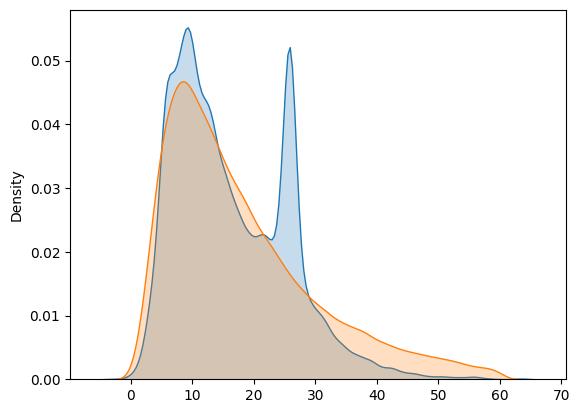

In [87]:
# LINEAR REGRESSION
lr = LinearRegression()
lr.fit(X=X_train, y=y_train)
eval_model(lr, X_val, y_val)

In [88]:
with open('models/lin_reg.bin', 'wb') as f_out:
  pickle.dump((dv, lr), f_out)

9.233436225720547


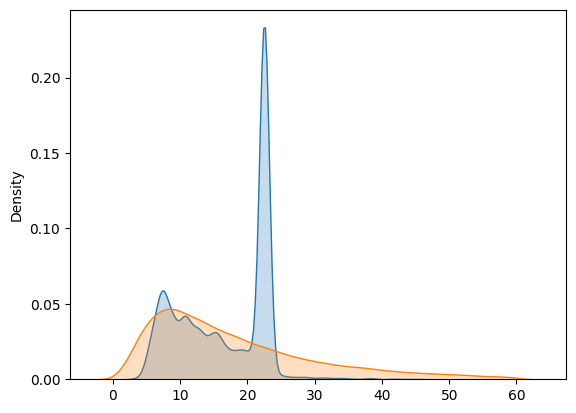

In [89]:
# LASSO REGRESSION
lasso = Lasso(alpha=.001)
lasso.fit(X=X_train, y=y_train)
eval_model(lasso, X_val, y_val)

7.703735100391448


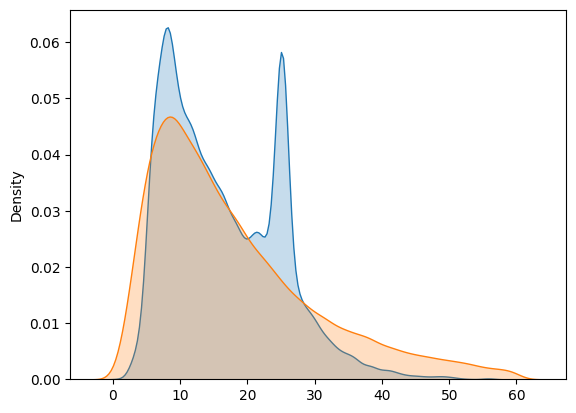

In [90]:
# RIDGE REGRESSION
ridge = Ridge()
ridge.fit(X=X_train, y=y_train)
eval_model(ridge, X_val, y_val)